## SpTransformer Predictions

In [1]:
import pandas as pd
import numpy as np
import tqdm
import os
import torch

# Don't use GPU in the notebook
os.environ['CUDA_VISIBLE_DEVICES'] = ''

# Import what we need from /home/elek/projects/SpliceTransformer
import sys
sys.path.append('/home/elek/projects/SpliceTransformer')
from tasks_annotate_mutations import SpTransformerDriver


Test that SpTransformer prediction works for a mock DNA sequence.

In [2]:
# Test the model with a mock sequence
input_seq = 'N'*4500 + 'ACGTAGGGCG' + 'N'*4500

# Encode and predict using the SpTransformerDriver default model
model = SpTransformerDriver(ref_fasta='', load_db=False, context=4500, weights="/home/elek/projects/SpliceTransformer/model/weights/SpTransformer_pytorch.ckpt")
input_encoded = model.one_hot_encode(input_seq)
output = model.calc_single_sequence(input_encoded, encode=False)

print(f"Input sequence length: {len(input_seq)}")
print(f"Output shape: {output.shape}")
print(f"Splice scores shape: {output[:, :3].shape}")
print(f"Tissue usage shape: {output[:, 3:].shape}")

torch device:cpu
Input sequence length: 9010
Output shape: (10, 18)
Splice scores shape: (10, 3)
Tissue usage shape: (10, 15)


By default, SpTransformer predicts values for 15 GTEx tissues. I am only interested in Brain and Heart for now, because I can compare them to SplicEvo predictions.

In [3]:
tis_dic = {0: 'Adipose Tissue', 1: 'Blood', 2: 'Blood Vessel', 3: 'Brain', 4: 'Colon', 5: 'Heart', 6: 'Kidney',
                7: 'Liver', 8: 'Lung', 9: 'Muscle', 10: 'Nerve', 11: 'Small Intestine', 12: 'Skin', 13: 'Spleen', 14: 'Stomach'}
tis_target = [3, 5]

Load test data used for SplicEvo.

In [4]:
# Load test data
test_path = "/home/elek/projects/splicing/results/data_processing/processed_data_test.npz"
data = np.load(test_path)

test_sequences = data['sequences']
test_labels = data['labels']

test_sse = data['usage_sse']
test_alpha = data['usage_alpha']
test_beta = data['usage_beta']

test_sse = np.nan_to_num(test_sse, nan=0.0)
test_alpha = np.nan_to_num(test_alpha, nan=0.0)
test_beta = np.nan_to_num(test_beta, nan=0.0)

print(f"Test sequences shape: {test_sequences.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Test usage shape: {test_sse.shape}")
print(f"Test alpha shape: {test_alpha.shape}")
print(f"Test beta shape: {test_beta.shape}")

Test sequences shape: (54043, 10000, 4)
Test labels shape: (54043, 1000)
Test usage shape: (54043, 1000, 7)
Test alpha shape: (54043, 1000, 7)
Test beta shape: (54043, 1000, 7)


Check that SpTransformer prediction works for batch of sequences.

In [5]:
output = model.calc_batched_sequence(test_sequences[0:10], encode=False)
splice_probs = output[:,:,:3]
splice_preds = np.argmax(splice_probs, axis=-1)
usage_preds = output[:,:,3:]

print(f"Output shape: {output.shape}")
print(f"Splice scores shape: {splice_probs.shape}")
print(f"Tissue usage shape: {usage_preds.shape}")

Output shape: (10, 1000, 18)
Splice scores shape: (10, 1000, 3)
Tissue usage shape: (10, 1000, 15)


Use SpliceTransformer for predictions on test data I used for SplicEvo.

```bash
conda activate sptransformer
python /home/elek/projects/splicing/scripts/sptransformer_predict.py \
--input /home/elek/projects/splicing/results/data_processing/processed_data_test.npz \
--output /home/elek/projects/splicing/results/sptransformer/test_predictions.npz \
--weights /home/elek/projects/SpliceTransformer/model/weights/SpTransformer_pytorch.ckpt
```

Load resulting predictions.

In [6]:
import numpy as np

# Load the model predictions from a file
pred_path = "/home/elek/projects/splicing/results/sptransformer/test_predictions.npz"
pred = np.load(pred_path)

# Keys in the loaded data
print(f"Available keys: {list(pred.keys())}")
for key in pred.keys():
    print(f"{key}: {pred[key].shape}")


Available keys: ['splice_preds', 'splice_probs', 'splice_usage', 'labels_true', 'usage_true']
splice_preds: (54043, 1000)
splice_probs: (54043, 1000, 3)
splice_usage: (54043, 1000, 15)
labels_true: (54043, 1000)
usage_true: (54043, 1000, 7)


SpTransformer works with the following predictions:  
0 - non-splice site, 1 - acceptor, 2 - donor.  

To calculate accuracy against true labels, I need to match outputs to what Splicevo reports:  
0 - non-splice site, 1 - donor, 2 - acceptor

In [15]:
# reorder columns of probabilities matrices
pred_probs = pred['splice_probs'][:,:, [0,2,1]]
# replace class values: 1 with 2 and 2 with 1
pred_preds = pred['splice_preds']
pred_preds[pred_preds == 1] = 3
pred_preds[pred_preds == 2] = 1
pred_preds[pred_preds == 3] = 2

Inspect a few sequences and their predicted splice sites.

In [17]:
# Splice sites in the first few test sequences
for i in range(6):
    print(f"\n(1) Donor splice sites in sequence {i}:")
    print(f"  actual       {np.where(test_labels[i] == 1)[0].tolist()}")
    print(f"  predicted    {np.where(pred_preds[i] == 1)[0].tolist()}")
    print(f"(2) Acceptor splice sites in sequence {i}:")
    print(f"  actual    {np.where(test_labels[i] == 2)[0].tolist()}")
    print(f"  predicted {np.where(pred_preds[i] == 2)[0].tolist()}")  


(1) Donor splice sites in sequence 0:
  actual       [0]
  predicted    []
(2) Acceptor splice sites in sequence 0:
  actual    []
  predicted []

(1) Donor splice sites in sequence 1:
  actual       []
  predicted    []
(2) Acceptor splice sites in sequence 1:
  actual    [973]
  predicted []

(1) Donor splice sites in sequence 2:
  actual       [13]
  predicted    []
(2) Acceptor splice sites in sequence 2:
  actual    []
  predicted []

(1) Donor splice sites in sequence 3:
  actual       []
  predicted    []
(2) Acceptor splice sites in sequence 3:
  actual    [0]
  predicted []

(1) Donor splice sites in sequence 4:
  actual       [463]
  predicted    []
(2) Acceptor splice sites in sequence 4:
  actual    [586]
  predicted []

(1) Donor splice sites in sequence 5:
  actual       []
  predicted    []
(2) Acceptor splice sites in sequence 5:
  actual    [0]
  predicted []


In [18]:
for i, j in [(0, 0), (1, 0), (2, 168), (2, 759)]:
    print(f"Sequence {i}, position {j}:\n  true label: {test_labels[i,j]}\n  pred label: {pred_preds[i,j]}\n  porbs:{pred_probs[i,j,]}")

Sequence 0, position 0:
  true label: 1
  pred label: 0
  porbs:[1.0000000e+00 1.8632171e-08 5.8214464e-08]
Sequence 1, position 0:
  true label: 0
  pred label: 0
  porbs:[9.9999976e-01 2.7942734e-08 2.7276121e-07]
Sequence 2, position 168:
  true label: 0
  pred label: 0
  porbs:[9.9999976e-01 1.8604939e-07 5.0143331e-08]
Sequence 2, position 759:
  true label: 0
  pred label: 0
  porbs:[9.9999797e-01 3.6267394e-07 1.6919980e-06]


Calculate PR-AUC, the area under the precision-recall curve.

In [21]:
class_idx = 1  # donor
pred_probs[:, :, class_idx].shape

(54043, 1000)

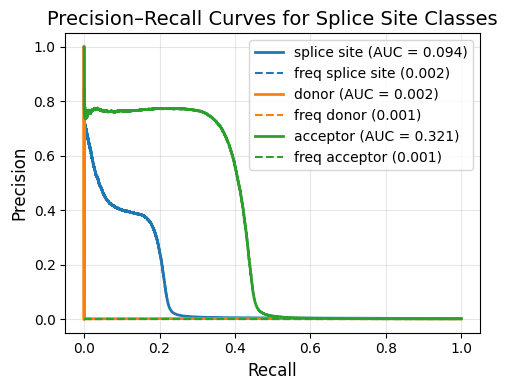

PR-AUC for splice site: 0.0942
PR-AUC for donor: 0.0015
PR-AUC for acceptor: 0.3214


In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

pr_auc_scores = {}
plt.figure(figsize=(5, 4))

class_labels = {0: 'splice site', 1: 'donor', 2: 'acceptor'}
class_colors = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green'}

total_positions = data['labels'].shape[0] * data['labels'].shape[1]

for class_idx in range(3):
    color = class_colors[class_idx]
    label = class_labels[class_idx]
    if class_idx == 0:
        y_true = (data['labels'] != class_idx).astype(int).reshape(-1)
        y_scores = 1 - pred_probs[:, :, class_idx].reshape(-1)
        freq = np.sum(data['labels'] != class_idx) / total_positions
    else:
        y_true = (data['labels'] == class_idx).astype(int).reshape(-1)
        y_scores = pred_probs[:, :, class_idx].reshape(-1)
        freq = np.sum(data['labels'] == class_idx) / total_positions

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    pr_auc_scores[class_idx] = pr_auc

    plt.plot(
        recall, precision,
        label=f"{label} (AUC = {pr_auc:.3f})",
        linewidth=2,
        color=color
    )
    plt.hlines(
        y=freq, xmin=0, xmax=1,
        colors=color, linestyles='dashed',
        label=f'freq {label} ({freq:.3f})'
    )

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision–Recall Curves for Splice Site Classes", fontsize=14)
plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("plots/pr_curves_sptransformer.pdf", dpi=300)
plt.show()

for c, auc_score in pr_auc_scores.items():
    print(f"PR-AUC for {class_labels[c]}: {auc_score:.4f}")


Calculate top-k accuracy by choosing a threshold to make predicted positive sites and actual positive sites have the same number, then computing the fraction of correctly predicted splice sites.

In [22]:
def top_k_accuracy(y_true, y_scores):
    # How many actual positive sites (k) are there?
    k = np.sum(y_true)
    # Select prediction value threshold at which there are k predicted positive sites
    threshold = np.sort(y_scores)[-k]
    # Predicted positive sites
    y_pred = (y_scores >= threshold).astype(int)
    # Calculate accuracy
    accuracy = np.sum((y_pred == 1) & (y_true == 1)) / k
    return accuracy

top_k_acc = {}
for class_idx in range(3):
    if class_idx == 0:
        y_true = (data['labels'] != class_idx).astype(int)
        y_scores = 1 - pred_probs[:, :, class_idx].reshape(-1)
    else:
        y_true = (data['labels'] == class_idx).astype(int)
        y_scores = pred_probs[:, :, class_idx].reshape(-1)
    y_true = y_true.reshape(-1)
    y_scores = y_scores.reshape(-1)
    acc = top_k_accuracy(y_true, y_scores)
    top_k_acc[class_idx] = acc
    print(f"Top-k accuracy for class {class_idx}: {acc:.4f}")

Top-k accuracy for class 0: 0.2057
Top-k accuracy for class 1: 0.0010
Top-k accuracy for class 2: 0.4199
